In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as Dataset
import torchvision.transforms as Transforms
import matplotlib.pyplot as plt
from tqdm import tqdm


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
NUM_EPOCH = 2
NUM_CLASSES = 47
BATCH_SIZE = 64
LEARNING_RATE = 0.01

### Dataset

In [5]:
#Download the dataset
train_dataset = Dataset.EMNIST(root="./data", train=True, transform=Transforms.ToTensor(), split="balanced", download=True)
test_dataset = Dataset.EMNIST(root="./data", train=False, transform=Transforms.ToTensor(), split="balanced", download=True)

In [6]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [7]:
# Normalize the dataset
mean = 0.0
std = 0.0
num_samples = 0


for data, lbls in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print(f'{mean=}; {std=}; {num_samples=}')

normalize_transform = Transforms.Normalize(mean=mean, std=std)

train_loader.transform = Transforms.Compose([
    Transforms.ToTensor(),
    normalize_transform
])

test_loader.transform = Transforms.Compose([
    Transforms.ToTensor(),
    normalize_transform
])



mean=tensor([0.1751]); std=tensor([0.3267]); num_samples=112800


In [24]:
for data, label in train_loader:
    print("Data shape:", data.shape)
    
    print("Label:", label)
    break

Data shape: torch.Size([64, 1, 28, 28])
Label: tensor([36, 36, 20, 38,  0, 22, 24, 23, 38, 45,  7, 26, 15, 36, 17, 16, 11,  1,
        11, 32, 23, 37, 28, 40,  5, 17, 12,  4, 35, 20, 28, 37, 26, 43, 21,  0,
        10, 40,  1, 24, 29,  4, 11, 25, 45,  5,  3, 20,  6, 21, 18,  9, 30,  2,
        37, 27, 11, 22, 38,  9, 45, 15, 41, 21])


number of classes 47


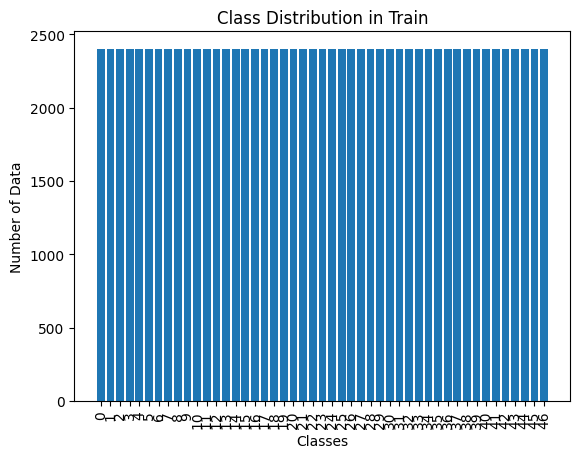

In [9]:
class_counts = {}

for values, labels in train_loader:
    for label in labels:
        if label.item() in class_counts:
            class_counts[label.item()] += 1
        else:
            class_counts[label.item()] = 1

classes = list(class_counts.keys())
counts = list(class_counts.values())
print(f'number of classes {len(classes)}')
NUM_CLASSES = len(classes)

# Plotting graph
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Data')
plt.title('Class Distribution in Train')
plt.xticks(classes)
plt.xticks(rotation=90)
plt.show()

In [45]:
VGG16 = [64, 64, 'M', 128,128,'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
VGG1 = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M']

In [11]:
class VGGNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, architecture=VGG16):
        super(VGGNet, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layer(VGG16)
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096), # size of feature map at end is 7*7
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096,num_classes)
        )
        self.softMax = nn.Softmax(dim=1) # not sure


    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fcs(out)
        out = self.softMax(out)
        return out

    def create_conv_layer(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3),stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)
        


In [62]:
class VGGNet1(nn.Module):
    def __init__(self, in_channels=1, num_classes=1000, architecture=VGG1):
        super(VGGNet1, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layer(VGG1)
        self.fcs = nn.Sequential(
            nn.Linear(6272, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048,num_classes)
        )
        self.softMax = nn.Softmax(dim=1)


    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fcs(out)
        out = self.softMax(out)
        return out

    def create_conv_layer(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3),stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)
        


In [63]:
model = VGGNet1(architecture=VGG1,in_channels=1, num_classes=NUM_CLASSES).to(device)
model

VGGNet1(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fcs): Sequential(
    (0): Linear(in_fe

In [64]:
def test():
    x = torch.randn(2, 1, 28, 28)
    print(x.shape)

    result = model(x.to(device))
    return result

fp = test()
fp

torch.Size([2, 1, 28, 28])


tensor([[0.0206, 0.0221, 0.0144, 0.0169, 0.0222, 0.0216, 0.0260, 0.0197, 0.0222,
         0.0248, 0.0233, 0.0170, 0.0196, 0.0220, 0.0230, 0.0235, 0.0296, 0.0167,
         0.0247, 0.0159, 0.0172, 0.0236, 0.0247, 0.0142, 0.0262, 0.0236, 0.0217,
         0.0167, 0.0280, 0.0182, 0.0202, 0.0363, 0.0261, 0.0254, 0.0181, 0.0183,
         0.0151, 0.0152, 0.0136, 0.0241, 0.0176, 0.0328, 0.0227, 0.0236, 0.0167,
         0.0148, 0.0195],
        [0.0377, 0.0191, 0.0147, 0.0165, 0.0252, 0.0230, 0.0249, 0.0198, 0.0254,
         0.0261, 0.0232, 0.0130, 0.0205, 0.0240, 0.0237, 0.0291, 0.0243, 0.0245,
         0.0257, 0.0148, 0.0175, 0.0199, 0.0208, 0.0141, 0.0208, 0.0176, 0.0217,
         0.0140, 0.0263, 0.0241, 0.0185, 0.0242, 0.0239, 0.0407, 0.0147, 0.0160,
         0.0246, 0.0178, 0.0148, 0.0194, 0.0179, 0.0216, 0.0190, 0.0148, 0.0177,
         0.0184, 0.0242]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [71]:
def train(model, epochs, criterion, optimizer, scheduler):
    train_losses = []
    train_acc = []

    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0

        print(f"Epoch: {i + 1}")

        for images, targets in tqdm(train_loader, desc= "Train\t"):
            images, targets = images.to(device), targets.to(device)

            # images = images.reshape(images.shape[0], -1) 

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)
            
        scheduler.step()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(running_correct / total)
        print(f'{total=}, {running_correct=}, {running_loss=}, {len(train_loader)=}')

    return train_losses, train_acc
            

In [72]:
# optimizer and loss and scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH, eta_min=0.001)

In [73]:
train_losses, train_acc = train(model,NUM_EPOCH,criterion,optimizer,scheduler )

Epoch: 1


Train	: 100%|██████████| 1763/1763 [00:19<00:00, 90.77it/s]


total=112800, running_correct=2400, running_loss=6813.598906755447, len(train_loader)=1763
Epoch: 2


Train	: 100%|██████████| 1763/1763 [00:18<00:00, 94.42it/s]

total=112800, running_correct=2400, running_loss=6813.614531755447, len(train_loader)=1763
